# Plotting Figure S1

This script is used to plot Figure S1 “SNR”

In [1]:
import xarray as xr
import datetime
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import time
import gc
import util
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader

## Step 1: Load 2006 and 2061 data

### CMIP

In [2]:
# Load CMIP
CMIP={}
path="../data/uhws/UHWs_CMIP/"
CMIP["diff_raw"]={}
CMIP["diff_stat"]={}
for year in ["2006","2061"]:
    CMIP[year]={}
    for vari in ["frequency","totaldays","intensity"]:
        CMIP[year][vari]=pd.read_csv(path+year+"_"+vari+".csv").set_index(["lat","lon"])
    CMIP[year]["duration"]=CMIP[year]["totaldays"]/CMIP[year]["frequency"]
    
for vari in ["frequency","totaldays","intensity","duration"]:
    CMIP["diff_raw"][vari] = CMIP["2061"][vari]-CMIP["2006"][vari]
    CMIP["diff_stat"][vari+"_diff_mean"] = CMIP["diff_raw"][vari].mean(axis=1)
    CMIP["diff_stat"][vari+"_diff_std"] = CMIP["diff_raw"][vari].std(axis=1)
    #CMIP["diff_stat"][vari+"_diff_0.025"] = CMIP["diff_raw"][vari].quantile(0.025,axis=1)
    CMIP["diff_stat"][vari+"_diff_SNR"] = CMIP["diff_stat"][vari+"_diff_mean"].abs()/CMIP["diff_stat"][vari+"_diff_std"]

"""
for keys in CMIP["diff_stat"]:
    print(keys)
    print(CMIP["diff_stat"][keys].describe())
"""
# Load CESM
CESM={}
path="../data/uhws/UHWs_CESM/"
CESM["diff_raw"]={}
CESM["diff_stat"]={}
for year in ["2006","2061"]:
    CESM[year]={}
    for vari in ["frequency","totaldays","intensity"]:
        CESM[year][vari]=pd.read_csv(path+year+"_"+vari+".csv").set_index(["lat","lon"])
    CESM[year]["duration"]=CESM[year]["totaldays"]/CESM[year]["frequency"]
    
for vari in ["frequency","totaldays","intensity","duration"]:
    CESM["diff_raw"][vari] = CESM["2061"][vari]-CESM["2006"][vari]
    CESM["diff_stat"][vari+"_diff_mean"] = CESM["diff_raw"][vari].mean(axis=1)
    CESM["diff_stat"][vari+"_diff_std"] = CESM["diff_raw"][vari].std(axis=1)
    #CESM["diff_stat"][vari+"_diff_0.025"] = CESM["diff_raw"][vari].quantile(0.025,axis=1)
    CESM["diff_stat"][vari+"_diff_SNR"] = CESM["diff_stat"][vari+"_diff_mean"].abs()/CESM["diff_stat"][vari+"_diff_std"]

"""
for keys in CESM["diff_stat"]:
    print(keys)
    print(CESM["diff_stat"][keys].describe())
"""

# merge CMIP with CESM member 002
merge_ens={}

for vari in ["frequency","totaldays","intensity","duration"]:
    merge_ens[vari]=pd.concat([CMIP["diff_raw"][vari].reset_index(),
                    CESM["diff_raw"][vari]["002_max"].reset_index()["002_max"]],
                    axis=1).set_index(["lat","lon"])
    merge_ens[vari+"_diff_mean"]=merge_ens[vari].mean(axis=1)
    merge_ens[vari+"_diff_std"]=merge_ens[vari].std(axis=1)
    merge_ens[vari+"_diff_SNR"]=merge_ens[vari+"_diff_mean"].abs()\
                                /merge_ens[vari+"_diff_std"]
#list(merge_ens)

## Step 2: Plot SNR

In [3]:
def setup_globe(ax):
    ax.set_extent([-180,180,-60,75],crs=ccrs.PlateCarree())
    ax.coastlines(zorder=5)
#     ax.add_feature(cartopy.feature.LAND, facecolor='lightgray',zorder=0)
    ax.add_feature(cartopy.feature.LAKES, facecolor='none',edgecolor='black',
                   linewidth=0.5,zorder=5)
    ax.add_feature(cartopy.feature.BORDERS,
                   facecolor='none',
                   edgecolor='black',
                   linewidth=0.5,zorder=5)

def setup_colorbar_text(ax,p,title_text,var_text):
    ax.set_xlabel("")
    ax.set_ylabel("")
    cbar = plt.colorbar(p, ax=ax,
                    orientation="vertical",
                    fraction=0.1,
                    shrink=0.80,
                    pad=0.02,
                    aspect=30,
                    extend="max")
    g = ax.gridlines(color='grey', linestyle='--', draw_labels=False,zorder=4)
    g.xlocator = mticker.FixedLocator([-90, 0, 90])
    lon_formatter = LongitudeFormatter()#zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    props = dict(boxstyle='round', facecolor='lightcyan')
    # place a text box in upper left in axes coords
    ax.text(0.03, 0.20, var_text, transform=ax.transAxes, fontsize=12,
             verticalalignment='top', bbox=props,zorder=6)
    ax.set_title(title_text, fontweight="bold", loc="left")
    
def plot_scatter(ax,df,vmin,vmax,cmap):
    df_temp = df.copy()
    df_temp["lon_new"] = np.where(df_temp['lon'] <= 180, 
                                  df_temp['lon'], 
                                  df_temp['lon']-360)
    p = ax.scatter(df_temp["lon"],df_temp["lat"],c=df_temp[0],
                   s=0.5,
                   vmin=vmin,
                   vmax=vmax,
                   cmap=cmap,
                   zorder=3,rasterized=True)
    
    return p
    
def plot_map(df,i,vmin,vmax,cmap,title_text,var_text):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    setup_globe(ax)
    if i==0: 
        ax.set_yticks(np.array([-60,-30,0,30,60]), crs=ccrs.PlateCarree())
    elif i==1:
        pass
    elif i==2:
        ax.set_xticks(np.linspace(-90, 90, 3), crs=ccrs.PlateCarree())
        ax.set_yticks(np.array([-60,-30,0,30,60]), crs=ccrs.PlateCarree())
    elif i==3:
        ax.set_xticks(np.linspace(-90, 90, 3), crs=ccrs.PlateCarree())
    p = plot_scatter(ax,df,vmin,vmax,cmap)
    setup_colorbar_text(ax,p,title_text,var_text) 

intensity


count    4439.000000
mean        2.435205
std         1.060927
min         0.009267
25%         1.662226
50%         2.245589
75%         3.024959
max         9.929899
dtype: float64

##########################################
frequency


count    4439.000000
mean        2.495828
std         0.783738
min         0.549113
25%         1.942247
50%         2.394831
75%         2.922478
max         7.661081
dtype: float64

##########################################
duration


count    4439.000000
mean        1.354583
std         0.455657
min         0.002827
25%         1.057271
50%         1.315691
75%         1.613784
max         3.512936
dtype: float64

##########################################
totaldays


count    4439.000000
mean        1.968042
std         0.524684
min         0.593906
25%         1.609129
50%         1.893767
75%         2.245804
max         4.907512
dtype: float64

##########################################


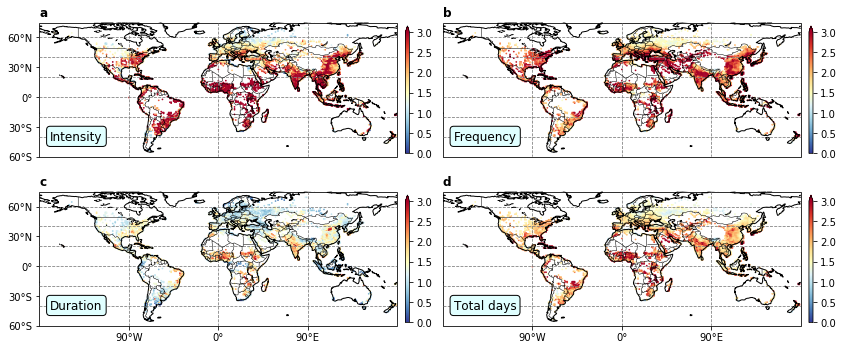

In [4]:
fig = plt.figure(figsize=(12,5))
cmap="RdYlBu_r"
#cmap="rainbow"

var_list=["intensity","frequency","duration","totaldays"]

max_val={"frequency":3,
         "totaldays":3,
         "intensity":3,
         "duration":3}

min_val={"frequency":0,
         "totaldays":0,
         "intensity":0,
         "duration":0}

var_text_dict={"frequency":"Frequency",
               "totaldays":"Total days",
               "intensity":"Intensity",
               "duration":"Duration"}

title_text_dict={"frequency":"b",
                 "totaldays":"d",
                 "intensity":"a",
                 "duration":"c"}

for i in range(4):
    var = var_list[i]
    print(var) 
    df = merge_ens[var+"_diff_SNR"]
    display(df.describe())
    
    plot_map(df.reset_index(),
             i,min_val[var], max_val[var],
             cmap,title_text_dict[var],var_text_dict[var])
    
    del df
    gc.collect()
    print("##########################################")
    
plt.tight_layout()
plt.savefig("../figures/SNR.pdf",dpi=188)
plt.show()